In [35]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
dh = DataHandler.from_specs("ERA5", "plev", "z", "6H", "all", "JJA", -80., 40., 15., 80., 500, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None)
exp_z = Experiment(dh)
metric = "euclidean"
nx = 6
ny = 4
kwargs_som = dict(
    nx=nx,
    ny=ny,
    metric=metric,
    return_type=RAW_REALSPACE,
    PBC=True,
)
net, centers, labels = exp_z.som_cluster(**kwargs_som)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_z.da.time, "cluster": np.arange(net.n_nodes)})

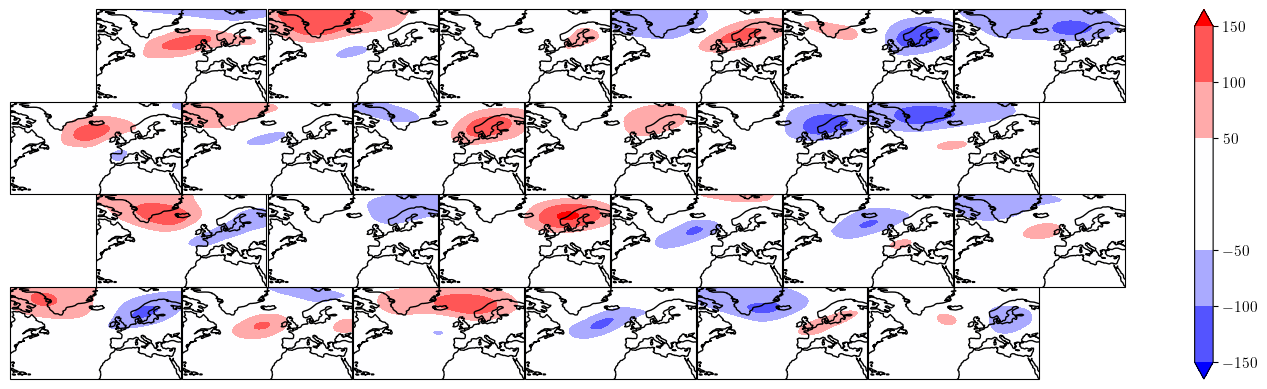

In [37]:
clu = Clusterplot(4, 6, get_region(centers), honeycomb=True)
from scipy import constants as co
_ = clu.add_contourf(centers / co.g, levels=5, cmap="bwr")

In [38]:
dh_T = DataHandler.from_specs(
    "ERA5", "surf", "t", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 15)}, None,
)
da_T = dh_T.da.load()
clu = Clusterplot(net.y, net.x, get_region(da_T), honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
_ = clu.add_any_contour_from_mask(
    da_T, mask, "contourf", levels=7, stippling=False, cbar_label="Temperature anomalies [°C]", cbar_kwargs=dict(pad=0.01), cmap='bwr', q=0.999
)

KeyboardInterrupt: 

100%|██████████| 24/24 [00:03<00:00,  7.88it/s]


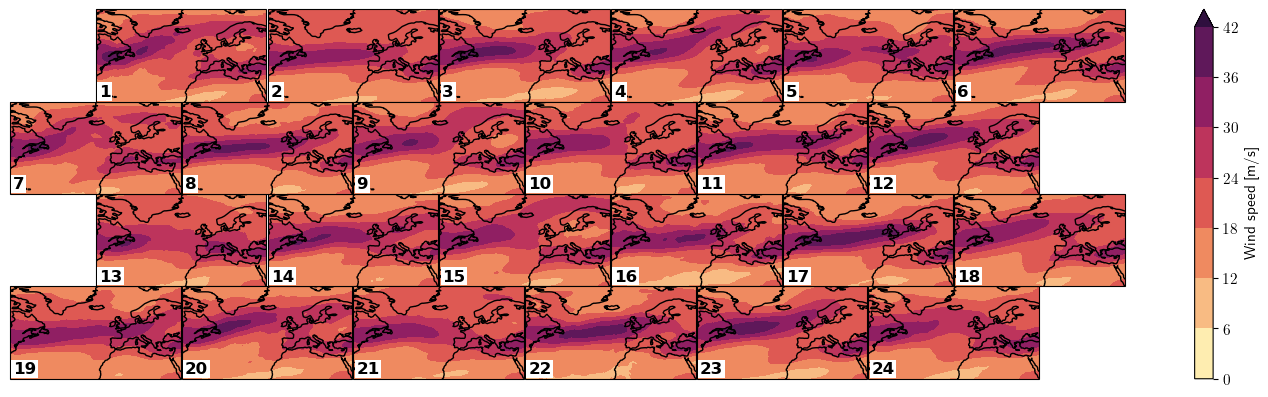

In [34]:
dh_s = DataHandler.from_specs(
    "ERA5", "plev", "s", "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], None, None, None, reduce_da=True
)
da_s = dh_s.da.load()
clu = Clusterplot(net.y, net.x, get_region(da_s), honeycomb=True, numbering=True)
for ax in clu.axes:
    ax.autoscale(False)
_ = clu.add_any_contour_from_mask(
    da_s, mask, "contourf", levels=7, stippling=False, cbar_label="Wind speed [m/s]", cmap=colormaps.matter, q=0.999
)

In [13]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.x
    maxdy = net.y
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

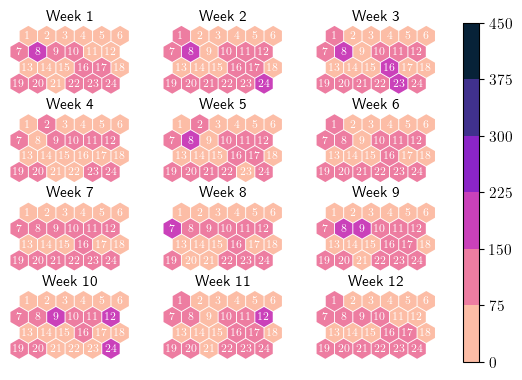

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 451, 75), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
# plt.savefig(f"{FIGURES}/som_props/weekly_pathway.png")

In [19]:
from scipy.stats import linregress
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
da = exp_z.da
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da)
nao_on_map = timeseries_on_map(nao_summer, net.latest_bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )


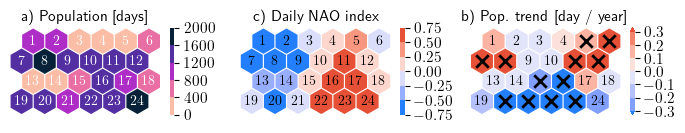

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.46), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Population [days]", pad=2)
cmap = colormaps.cet_d_bwr
fig, axes[2] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    norm=BoundaryNorm(np.linspace(-0.3, 0.3, 7), cmap.N, extend="both"),
    fig=fig,
    ax=axes[2],
)
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
# axes[2].scatter(*coords.T, s=260, edgecolors="black", marker="h", linewidths=1., facecolors="none")
axes[2].scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
axes[2].set_title("b) Pop. trend [day / year]", pad=2)
fig, axes[1] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[1],
    cmap=cmap,
    # discretify=True,
    norm=BoundaryNorm(np.linspace(-0.75, 0.75, 7), cmap.N)
)
axes[1].set_title("c) Daily NAO index", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j == 0 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
# fig.savefig(f'{FIGURES}/som_props/pop_nao_trend.png')

In [25]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(None, 1, yearbreaks=yearbreak)

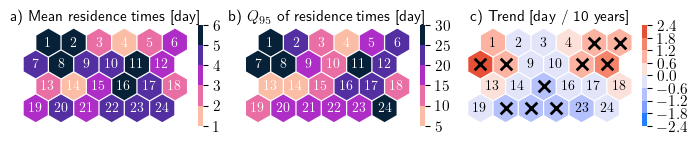

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    norm=BoundaryNorm([1, 2, 3, 4, 5, 6], cmap.N, extend="neither"),
    # discretify=True,
    cbar_kwargs=dict(shrink=0.85, spacing="proportional")
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
# fig.savefig(f'{FIGURES}/som_props/residence_sigma1.png')

In [45]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
all_jets_one_df = exp.find_jets()
props_as_df = exp.props_as_df(True)
jet_pos_da = jet_position_as_da(all_jets_one_df, exp.path)
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

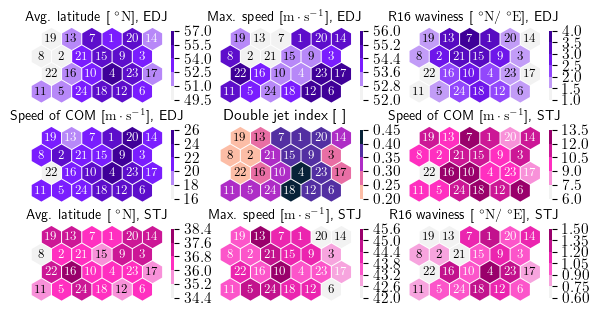

In [47]:
data_vars_and_jets = [
    ("mean_lat", "EDJ"),
    ("s_star", "EDJ"),
    ("wavinessR16", "EDJ"),
    ("com_speed", "EDJ"),
    ("double_jet_index", "STJ"),
    ("com_speed", "STJ"),
    ("mean_lat", "STJ"),
    ("s_star", "STJ"),
    ("wavinessR16", "STJ"),
]
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for (varname, jet), (j, ax) in zip(data_vars_and_jets, enumerate(axes)):
    to_plot = props_as_df_summer.filter(pl.col("jet") == jet)[varname]
    if varname == "double_jet_index":
        cmap = colormaps.bubblegum_r
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    else:
        cmap = MYPURPLES if jet == "EDJ" else MYPINKS
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
    to_plot = timeseries_on_map(to_plot, net.latest_bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        cbar_kwargs=dict(shrink=0.8)
    )
    norm = BoundaryNorm(MaxNLocator(7).tick_values(np.amin(to_plot), np.amax(to_plot)), cmap.N)
    for i, c in enumerate(coords):
        darkness = norm(to_plot[i]) / cmap.N
        x, y = c
        # color = "white" if j == 4 else "black"
        color = "white" if darkness > 0.3 else "black"
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=9)
# fig.savefig(f'{FIGURES}/som_props/combined_indices.png')